In [1]:
import jieba
import pandas as pd
import numpy as np
import requests
import datetime
import hashlib
import base64
import hmac
import json
import time

In [6]:
class get_result(object):
    def __init__(self,host,text,BusinessArgs):
        # 应用ID（到控制台获取）
        self.APPID = "5f9bc6e9"
        # 接口APISercet（到控制台机器翻译服务页面获取）
        self.Secret = "b4e7b50787941dc5f125be32b60899fb"
        # 接口APIKey（到控制台机器翻译服务页面获取）
        self.APIKey= "6678ddb9a98bf9b4fcf570cf9f52c570"
        
        
        # 以下为POST请求
        self.Host = host
        self.RequestUri = "/v2/its"
        # 设置url
        # print(host)
        self.url="https://"+host+self.RequestUri
        self.HttpMethod = "POST"
        self.Algorithm = "hmac-sha256"
        self.HttpProto = "HTTP/1.1"

        # 设置当前时间
        curTime_utc = datetime.datetime.utcnow()
        self.Date = self.httpdate(curTime_utc)
        # 设置业务参数
        # 语种列表参数值请参照接口文档：https://www.xfyun.cn/doc/nlp/xftrans/API.html
        self.Text=text
        self.BusinessArgs=BusinessArgs


    def hashlib_256(self, res):
        m = hashlib.sha256(bytes(res.encode(encoding='utf-8'))).digest()
        result = "SHA-256=" + base64.b64encode(m).decode(encoding='utf-8')
        return result

    def httpdate(self, dt):
        """
        Return a string representation of a date according to RFC 1123
        (HTTP/1.1).

        The supplied date must be in UTC.

        """
        weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][dt.weekday()]
        month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
                 "Oct", "Nov", "Dec"][dt.month - 1]
        return "%s, %02d %s %04d %02d:%02d:%02d GMT" % (weekday, dt.day, month,
                                                        dt.year, dt.hour, dt.minute, dt.second)

    def generateSignature(self, digest):
        signatureStr = "host: " + self.Host + "\n"
        signatureStr += "date: " + self.Date + "\n"
        signatureStr += self.HttpMethod + " " + self.RequestUri \
                        + " " + self.HttpProto + "\n"
        signatureStr += "digest: " + digest
        signature = hmac.new(bytes(self.Secret.encode(encoding='utf-8')),
                             bytes(signatureStr.encode(encoding='utf-8')),
                             digestmod=hashlib.sha256).digest()
        result = base64.b64encode(signature)
        return result.decode(encoding='utf-8')

    def init_header(self, data):
        digest = self.hashlib_256(data)
        #print(digest)
        sign = self.generateSignature(digest)
        authHeader = 'api_key="%s", algorithm="%s", ' \
                     'headers="host date request-line digest", ' \
                     'signature="%s"' \
                     % (self.APIKey, self.Algorithm, sign)
        #print(authHeader)
        headers = {
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Method": "POST",
            "Host": self.Host,
            "Date": self.Date,
            "Digest": digest,
            "Authorization": authHeader
        }
        return headers

    def get_body(self):
        content = str(base64.b64encode(self.Text.encode('utf-8')), 'utf-8')
        postdata = {
            "common": {"app_id": self.APPID},
            "business": self.BusinessArgs,
            "data": {
                "text": content,
            }
        }
        body = json.dumps(postdata)
        #print(body)
        return body

    def call_url(self):
        if self.APPID == '' or self.APIKey == '' or self.Secret == '':
            print('Appid 或APIKey 或APISecret 为空！请打开demo代码，填写相关信息。')
        else:
            code = 0
            body=self.get_body()
            headers=self.init_header(body)
            #print(self.url)
            response = requests.post(self.url, data=body, headers=headers,timeout=8)
            status_code = response.status_code
            #print(response.content)
            if status_code!=200:
                # 鉴权失败
                print("Http请求失败，状态码：" + str(status_code) + "，错误信息：" + response.text)
                print("请根据错误信息检查代码，接口文档：https://www.xfyun.cn/doc/nlp/xftrans/API.html")
            else:
                # 鉴权成功
                respData = json.loads(response.text)
                return respData['data']['result']['trans_result']['dst']
                # 以下仅用于调试
                code = str(respData["code"])
                if code!='0':
                    print("请前往https://www.xfyun.cn/document/error-code?code=" + code + "查询解决办法")



In [7]:
def retrans(text):
    host = "itrans.xfyun.cn"
    Args1={"from": "cn","to": "en",}
    Args2={"from": "en","to": "cn",}
    gClass1=get_result(host,text=text,BusinessArgs=Args1)
    trans=gClass1.call_url()
    
    gClass2=get_result(host,text=trans,BusinessArgs=Args2)
    return gClass2.call_url()

In [2]:
#data=pd.read_csv("multi.csv",usecols=['title','fact','opinion','inhibition','fff','activation','moral'])
weibodata=pd.read_csv("labeledData.csv",usecols=['review','label'])

In [22]:
stopwords=pd.read_csv("cn_stopwords.txt",encoding='utf-8',engine='python')


In [9]:

def cut_stop(prelist):
    l=[i for i in jieba.lcut(prelist) if i not in stopwords]
    return l
    

In [5]:
#test['trans']=test['title'].apply(retrans)

In [23]:
#data['cut']=[cut_stop(i) for i in data['title'].astype(str)]
weibodata['cut']=[cut_stop(i) for i in weibodata['review'].astype(str)]
weibodata['fullcut']=weibodata['review'].apply(lambda x: jieba.lcut(x))

In [24]:
#data['length']=[ len(i) for i in data['cut']]
weibodata['length']=[len(i) for i in weibodata['cut']]

In [25]:
np.mean(weibodata['length'])

18.395692307692308

In [26]:
np.median(weibodata['length'])

13.0

In [27]:
weibodata=weibodata.drop(weibodata[weibodata.length>100].index)
#data=data.drop(data[data.length>200 ].index)

In [15]:
#np.mean(data['length'])

In [16]:
#np.median(data['length'])

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [18]:
%matplotlib inline

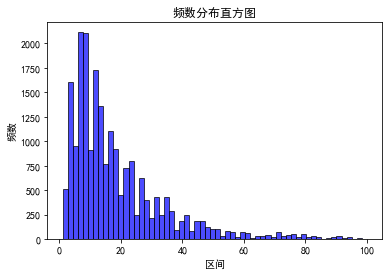

In [19]:
da=weibodata['length'].tolist()
plt.hist(da, bins=60, facecolor="blue", edgecolor="black", alpha=0.7)
matplotlib.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("区间")
 # 显示纵轴标签
plt.ylabel("频数")
 # 显示图标题
plt.title("频数分布直方图")

plt.show()

In [20]:
from gensim.models import word2vec
import gensim

In [28]:
sentences=weibodata['fullcut'].tolist()

In [29]:
model=word2vec.Word2Vec(sentences,min_count=1)

In [30]:
model.save("weibomodel")

In [31]:
vocab=model.wv.vocab
vectors=model.wv.vectors

In [32]:
with open("wvmodel.txt",'w',encoding='utf-8') as f:
    f.write(str(vectors.shape[0]))
    f.write(" ")
    f.write(str(vectors.shape[1]))
    f.write("\n")
    for voc,vec in zip(vocab,vectors):
        f.write(str(voc)+" ")
        f.write(" ".join(str(i) for i in vec))
        f.write("\n")
        

In [33]:
weibodata.to_csv("weibodata.csv")

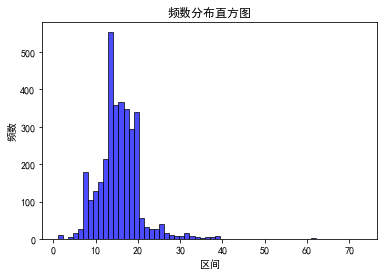

In [34]:
data=pd.read_csv("multi.csv",usecols=['title','fact','opinion','inhibition','fff','activation','moral'])
data['cut']=[cut_stop(i) for i in data['title'].astype(str)]
data['length']=[ len(i) for i in data['cut']]
data=data.drop(data[data.length>200 ].index)

da=data['length'].tolist()
plt.hist(da, bins=60, facecolor="blue", edgecolor="black", alpha=0.7)
matplotlib.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("区间")
 # 显示纵轴标签
plt.ylabel("频数")
 # 显示图标题
plt.title("频数分布直方图")

plt.show()

In [35]:
data=data.drop(data[data.length>30 ].index)

In [36]:
data.to_csv("yqdata.csv")